# Imports

In [6]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define genre EQ profiles

In [14]:
# Predefine equalization profiles for each genre.
# Each profile is an array of 10 values (gains in decibels) corresponding to:
# [32, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000 Hz]
genre_profiles = {
    'blues':     np.array([-1,  0,  2,  2,  1,  0, -1,  0,  1,  1]),
    'classical': np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
    'country':   np.array([ 0,  1,  1,  2,  1,  0,  0,  0,  0,  0]),
    'disco':     np.array([ 2,  3,  2,  1,  0,  0,  1,  2,  3,  2]),
    'hiphop':    np.array([ 3,  4,  2,  0, -1, -1,  0,  1,  1,  0]),
    'jazz':      np.array([ 0,  1,  1,  2,  2,  1,  0,  0,  1,  0]),
    'metal':     np.array([ 2,  3,  0, -3, -4, -3,  0,  3,  3,  2]),
    'pop':       np.array([ 0,  1,  2,  2,  1,  0,  1,  1,  2,  2]),
    'reggae':    np.array([ 0,  1,  0,  0, -1, -1,  0,  0,  1,  0]),
    'rock':      np.array([ 1,  1,  0,  0,  1,  1,  0,  0,  1,  1])
}

# Ensure this order matches the model's output order.
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def weighted_eq_profile(predictions, genre_list=genres, profiles=genre_profiles):
    """
    Given a predictions vector (softmax output over genres), compute a weighted
    equalization profile based on the top three predicted genres.
    
    Parameters:
      predictions: numpy array of shape (10,) with probabilities for each genre.
      genre_list: list of genre names in the order corresponding to predictions.
      profiles: dictionary mapping genre names to their equalization profile (numpy array).
      
    Returns:
      weighted_profile: numpy array of shape (10,) representing the weighted EQ profile.
    """
    # Get indices of the top 3 predicted genres.
    top3_idx = predictions.argsort()[-3:][::-1]
    top3_probs = predictions[top3_idx]
    
    # Normalize the top 3 probabilities so they sum to 1.
    weight_sum = np.sum(top3_probs)
    if weight_sum == 0:
        norm_weights = np.ones_like(top3_probs) / 3
    else:
        norm_weights = top3_probs / weight_sum
    
    # Compute the weighted combination of the equalization profiles.
    weighted_profile = np.zeros_like(profiles[genre_list[0]], dtype=float)
    for i, idx in enumerate(top3_idx):
        genre = genre_list[idx]
        profile = profiles[genre]
        weighted_profile += norm_weights[i] * profile
    
    return weighted_profile

# Define or get CNN

In [26]:
model_save_path_keras = "./saved_models/CONEqNet.keras"
model_save_path_h5 = "./saved_models/CONEqNet.h5"

if os.path.exists(model_save_path_keras):
    model = tf.keras.models.load_model(model_save_path_keras)
    print(f"Loaded existing model from {model_save_path_keras}")
elif os.path.exists(model_save_path_h5):
    model = tf.keras.models.load_model(model_save_path_h5)
    print(f"Loaded existing model from {model_save_path_h5}")
else:
    # 600 time steps, 13 MFCC coefficients, 1 channel (grayscale-like image)
    print("No saved model found, creating a new one...")
    input_shape = (600, 13, 1)

    model = Sequential()

    # Low-Level Features (Input):
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Mid-Level Features (Convolutional Layers):
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Upper-Level features (fully connected layers and output):
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("New model successfully compiled.")
    model.summary()

No saved model found, creating a new one...
New model successfully compiled.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 598, 11, 32)       320       
                                                                 
 batch_normalization_2 (Batc  (None, 598, 11, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 299, 5, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 297, 3, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 297, 3, 64)       256       
 hNormalization)                           

# Training

### Prepare Data

In [22]:
# Define the paths (note: genres are inside a subfolder per genre)
data_dir = './Data'
audio_dir = os.path.normpath(os.path.join(data_dir, 'genres_original'))
csv_path = os.path.normpath(os.path.join(data_dir, 'features_30_sec.csv'))

df_features = pd.read_csv(csv_path)

df_features['filepath'] = df_features.apply(lambda row: os.path.join(audio_dir, row['label'], row['filename']), axis=1)
print("\nAdded filepath to dataframe features.")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
label_to_index = {genre: i for i, genre in enumerate(genres)}

def extract_mfcc(file_path, n_mfcc=13, hop_length=1103):
    y, sr = librosa.load(file_path, duration=30)
        
    # the resulting shape is (n_mfcc, n_frames)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfcc

# extract MFCCs for each audio file
def prepare_data(df, target_frames=600, n_mfcc=13, hop_length=1103):
    X = []
    y = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            mfcc = extract_mfcc(row['filepath'], n_mfcc=n_mfcc, hop_length=hop_length)
            mfcc = mfcc.T
            # pad/truncate
            if mfcc.shape[0] < target_frames:
                pad_width = target_frames - mfcc.shape[0]
                mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
            elif mfcc.shape[0] > target_frames:
                mfcc = mfcc[:target_frames, :]
                
            mfcc = mfcc[..., np.newaxis]
            X.append(mfcc)
            y.append(label_to_index[row['label']])
        except Exception as e:
            print("Error processing {}: {}".format(row['filepath'], e))
    return np.array(X), np.array(y)


Added filepath to dataframe features.


 ### Make tensorflow use GPU

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected and enabled:", gpus)
    except RuntimeError as e:
        print("Error enabling GPU:", e)
else:
    print("No GPU detected. Running on CPU.")


Error enabling GPU: Physical devices cannot be modified after being initialized


### Train test split and data prep

In [23]:
train_df, val_df = train_test_split(df_features, test_size=0.2, stratify=df_features['label'], random_state=123)
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

# Prepare training and validation data
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=len(genres))
y_val_cat = to_categorical(y_val, num_classes=len(genres))

Train set shape: (800, 61)
Validation set shape: (200, 61)


 58%|█████▊    | 463/800 [00:10<00:07, 47.09it/s]C:\Users\rauli\AppData\Local\Temp\ipykernel_22864\3909490437.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
c:\venvs\ai\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 59%|█████▊    | 469/800 [00:10<00:06, 50.51it/s]

Error processing Data\genres_original\jazz\jazz.00054.wav: 


100%|██████████| 200/200 [00:04<00:00, 44.84it/s]


### Train

In [27]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val_cat.shape)

# Training details:
# - Batch size: 64
# - Epochs: 100 000 epochs
# - Learning rate: 0.001 via the Adam optimizer
# - Loss: Categorical Crossentropy

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

history = model.fit(
    X_train, y_train_cat,
    batch_size=256,
    epochs=100000,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, reduce_lr]
)

# Print final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print("\nFinal Training Accuracy: {:.2f}%".format(final_train_acc * 100))
print("Final Validation Accuracy: {:.2f}%".format(final_val_acc * 100))

X_train shape: (799, 600, 13, 1)
y_train shape: (799, 10)
X_val shape: (200, 600, 13, 1)
y_val shape: (200, 10)
Epoch 1/100000
4/4 [==============================] - 1s 126ms/step - loss: 7.4686 - accuracy: 0.1627 - val_loss: 9.2882 - val_accuracy: 0.0550 - lr: 0.0010
Epoch 2/100000
4/4 [==============================] - 0s 65ms/step - loss: 2.5332 - accuracy: 0.2466 - val_loss: 2.3012 - val_accuracy: 0.2150 - lr: 0.0010
Epoch 3/100000
4/4 [==============================] - 0s 72ms/step - loss: 1.8998 - accuracy: 0.3091 - val_loss: 2.1804 - val_accuracy: 0.2250 - lr: 0.0010
Epoch 4/100000
4/4 [==============================] - 0s 67ms/step - loss: 1.8776 - accuracy: 0.3317 - val_loss: 2.4577 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/100000
4/4 [==============================] - 0s 64ms/step - loss: 1.8039 - accuracy: 0.3354 - val_loss: 2.5436 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 6/100000
4/4 [==============================] - 0s 68ms/step - loss: 1.8023 - accuracy: 0.3367 - val_

### Save model

In [29]:
# Define the save paths
model_save_path_keras = "./saved_models/CONEqNet.keras"
model_save_path_h5 = "./saved_models/CONEqNet.h5"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path_keras), exist_ok=True)

# Save the model in TensorFlow's recommended format (.keras)
model.save(model_save_path_keras)
print(f"Model saved successfully to {model_save_path_keras}")

# Save the model in HDF5 format (.h5) for compatibility with older Keras versions
model.save(model_save_path_h5)
print(f"Model saved successfully to {model_save_path_h5}")

Model saved successfully to ./saved_models/CONEqNet.keras
Model saved successfully to ./saved_models/CONEqNet.h5


# Evaluate the model

Making predictions on validation set...
7/7 [==============================] - 0s 18ms/step
Overall Validation Accuracy: 0.5750 (57.50%)

Detailed Classification Report:
              precision    recall  f1-score   support

       blues       0.52      0.60      0.56        20
   classical       0.70      0.95      0.81        20
     country       0.41      0.55      0.47        20
       disco       0.41      0.45      0.43        20
      hiphop       0.61      0.55      0.58        20
        jazz       0.55      0.55      0.55        20
       metal       0.75      0.75      0.75        20
         pop       0.59      0.50      0.54        20
      reggae       0.59      0.50      0.54        20
        rock       0.78      0.35      0.48        20

    accuracy                           0.57       200
   macro avg       0.59      0.57      0.57       200
weighted avg       0.59      0.57      0.57       200


Per-Genre Performance Summary:
       Genre  Precision  Recall  F1-Sco

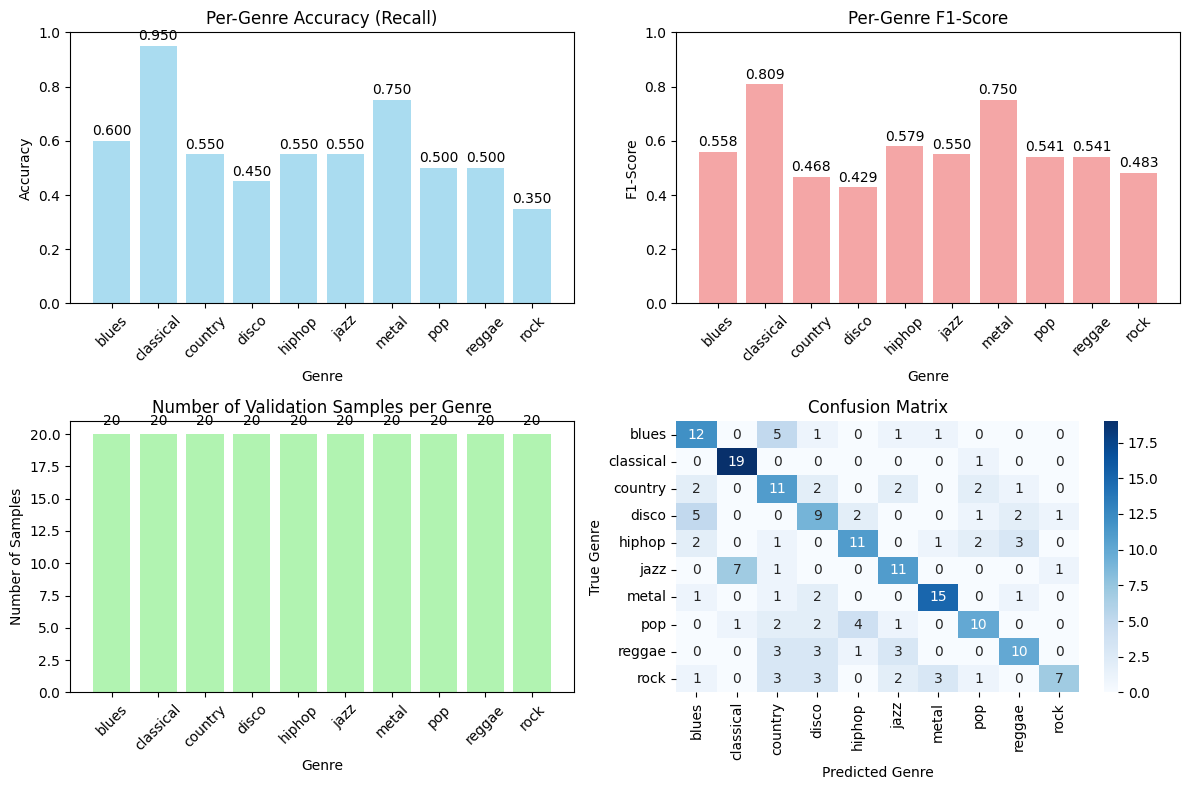


Confusion Matrix Analysis:

BLUES (True):
  -> Predicted as blues: 0.600 (60.0%)
  -> Predicted as country: 0.250 (25.0%)

CLASSICAL (True):
  -> Predicted as classical: 0.950 (95.0%)

COUNTRY (True):
  -> Predicted as blues: 0.100 (10.0%)
  -> Predicted as country: 0.550 (55.0%)
  -> Predicted as disco: 0.100 (10.0%)
  -> Predicted as jazz: 0.100 (10.0%)
  -> Predicted as pop: 0.100 (10.0%)

DISCO (True):
  -> Predicted as blues: 0.250 (25.0%)
  -> Predicted as disco: 0.450 (45.0%)
  -> Predicted as hiphop: 0.100 (10.0%)
  -> Predicted as reggae: 0.100 (10.0%)

HIPHOP (True):
  -> Predicted as blues: 0.100 (10.0%)
  -> Predicted as hiphop: 0.550 (55.0%)
  -> Predicted as pop: 0.100 (10.0%)
  -> Predicted as reggae: 0.150 (15.0%)

JAZZ (True):
  -> Predicted as classical: 0.350 (35.0%)
  -> Predicted as jazz: 0.550 (55.0%)

METAL (True):
  -> Predicted as disco: 0.100 (10.0%)
  -> Predicted as metal: 0.750 (75.0%)

POP (True):
  -> Predicted as country: 0.100 (10.0%)
  -> Predicted as

In [28]:
# %% [markdown]
# # Model Evaluation by Genre

# %%
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation set
print("Making predictions on validation set...")
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# Calculate overall accuracy
overall_accuracy = np.mean(y_pred == y_true)
print(f"Overall Validation Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Generate classification report
print("\nDetailed Classification Report:")
print("="*50)
report = classification_report(y_true, y_pred, target_names=genres, output_dict=True)
print(classification_report(y_true, y_pred, target_names=genres))

# Create a DataFrame for better visualization of per-genre metrics
genre_metrics = []
for i, genre in enumerate(genres):
    genre_data = {
        'Genre': genre,
        'Precision': report[genre]['precision'],
        'Recall': report[genre]['recall'],
        'F1-Score': report[genre]['f1-score'],
        'Support': report[genre]['support']
    }
    genre_metrics.append(genre_data)

metrics_df = pd.DataFrame(genre_metrics)
print("\nPer-Genre Performance Summary:")
print("="*50)
print(metrics_df.round(4))

# Visualize per-genre accuracy (which is the same as recall for each class)
plt.figure(figsize=(12, 8))

# Plot 1: Per-genre accuracy/recall
plt.subplot(2, 2, 1)
plt.bar(genres, [report[genre]['recall'] for genre in genres], 
        color='skyblue', alpha=0.7)
plt.title('Per-Genre Accuracy (Recall)')
plt.xlabel('Genre')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, genre in enumerate(genres):
    plt.text(i, report[genre]['recall'] + 0.01, f"{report[genre]['recall']:.3f}", 
             ha='center', va='bottom')

# Plot 2: F1-Score comparison
plt.subplot(2, 2, 2)
plt.bar(genres, [report[genre]['f1-score'] for genre in genres], 
        color='lightcoral', alpha=0.7)
plt.title('Per-Genre F1-Score')
plt.xlabel('Genre')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, genre in enumerate(genres):
    plt.text(i, report[genre]['f1-score'] + 0.01, f"{report[genre]['f1-score']:.3f}", 
             ha='center', va='bottom')

# Plot 3: Support (number of samples per genre in validation set)
plt.subplot(2, 2, 3)
plt.bar(genres, [report[genre]['support'] for genre in genres], 
        color='lightgreen', alpha=0.7)
plt.title('Number of Validation Samples per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
for i, genre in enumerate(genres):
    plt.text(i, report[genre]['support'] + 0.5, f"{int(report[genre]['support'])}", 
             ha='center', va='bottom')

# Plot 4: Confusion Matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("\nConfusion Matrix Analysis:")
print("="*50)
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
for i, true_genre in enumerate(genres):
    print(f"\n{true_genre.upper()} (True):")
    for j, pred_genre in enumerate(genres):
        if cm_normalized[i, j] > 0.05:  # Only show significant confusions (>5%)
            print(f"  -> Predicted as {pred_genre}: {cm_normalized[i, j]:.3f} ({cm_normalized[i, j]*100:.1f}%)")

# Find best and worst performing genres
best_genre_idx = np.argmax([report[genre]['f1-score'] for genre in genres])
worst_genre_idx = np.argmin([report[genre]['f1-score'] for genre in genres])

print(f"\nBest performing genre: {genres[best_genre_idx]} (F1: {report[genres[best_genre_idx]]['f1-score']:.4f})")
print(f"Worst performing genre: {genres[worst_genre_idx]} (F1: {report[genres[worst_genre_idx]]['f1-score']:.4f})")

# Calculate and display confidence statistics
print(f"\nPrediction Confidence Statistics:")
print("="*50)
max_probs = np.max(y_pred_probs, axis=1)
print(f"Average prediction confidence: {np.mean(max_probs):.4f}")
print(f"Median prediction confidence: {np.median(max_probs):.4f}")
print(f"Min prediction confidence: {np.min(max_probs):.4f}")
print(f"Max prediction confidence: {np.max(max_probs):.4f}")

# Show confidence distribution by correctness
correct_predictions = (y_pred == y_true)
correct_confidences = max_probs[correct_predictions]
incorrect_confidences = max_probs[~correct_predictions]

print(f"\nConfidence for correct predictions: {np.mean(correct_confidences):.4f} ± {np.std(correct_confidences):.4f}")
print(f"Confidence for incorrect predictions: {np.mean(incorrect_confidences):.4f} ± {np.std(incorrect_confidences):.4f}")

# Optional: Save results to CSV
results_summary = {
    'overall_accuracy': overall_accuracy,
    'genre_metrics': metrics_df,
    'confusion_matrix': cm
}

# Save the metrics DataFrame
metrics_df.to_csv('./evaluation_results.csv', index=False)
print(f"\nGenre-wise metrics saved to './evaluation_results.csv'")